# SDO/AIA and Solar Orbiter/EUI alignment tutorial

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import astropy

import sunpy
import sunpy.map
import sunpy_soar
from sunpy.net import Fido, attrs as a

import astropy.units as u

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Retriving the data

We will use Fido to retrive data which is a search tool that is part of SunPy.

In [16]:
# EUI
instrument = a.Instrument('EUI')
time = a.Time('2022-03-05 15:20:00', '2022-03-05 16:10:00')
level = a.Level(2)
product = a.soar.Product('eui-hrieuv174-image')  # changed from all caps to no caps

eui_result = Fido.search(instrument & time & level & product)
print(eui_result)

Results from 1 Provider:

600 Results from the SOARClient:

Instrument     Data product    Level ... Filesize               SOOP Name               
                                     ...  Mbyte                                         
---------- ------------------- ----- ... -------- --------------------------------------
       EUI eui-hrieuv174-image    L2 ...    5.291 L_SMALL_HRES_HCAD_Slow-Wind-Connection
       EUI eui-hrieuv174-image    L2 ...    5.132 L_SMALL_HRES_HCAD_Slow-Wind-Connection
       EUI eui-hrieuv174-image    L2 ...     5.17 L_SMALL_HRES_HCAD_Slow-Wind-Connection
       EUI eui-hrieuv174-image    L2 ...    5.152 L_SMALL_HRES_HCAD_Slow-Wind-Connection
       EUI eui-hrieuv174-image    L2 ...    5.149 L_SMALL_HRES_HCAD_Slow-Wind-Connection
       ...                 ...   ... ...      ...                                    ...
       EUI eui-hrieuv174-image    L2 ...    5.524 L_SMALL_HRES_HCAD_Slow-Wind-Connection
       EUI eui-hrieuv174-image    L2 ...    5.196 

Let's download the EUI files we queried for

In [17]:
eui_files = Fido.fetch(eui_result)

Files Downloaded:   0%|          | 0/600 [00:00<?, ?file/s]

Observatory,Solar Orbiter
Instrument,EUI
Detector,HRI_EUV
Measurement,174.0 Angstrom
Wavelength,174.0 Angstrom
Observation Date,2022-03-05 15:36:21
Exposure Time,2.8 s
Dimension,[2048. 2048.] pix
Coordinate System,helioprojective
Scale,[0.492 0.492] arcsec / pix
Reference Pixel,[895.5 959.5] pix

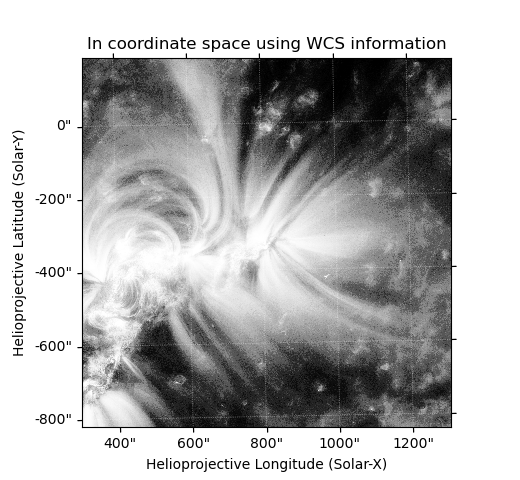
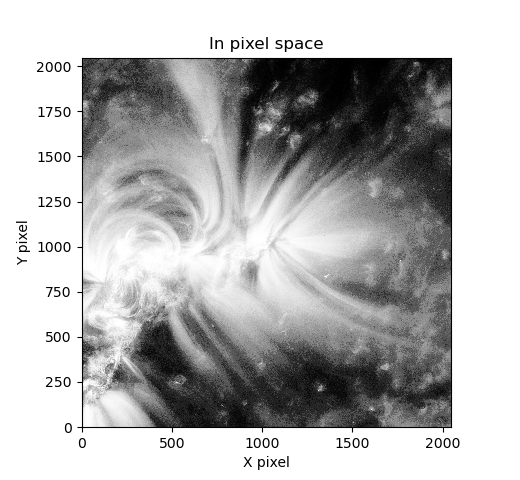
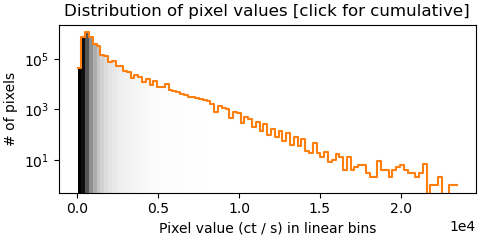
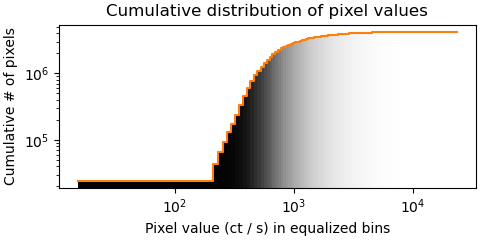

In [18]:
sunpy.map.Map(eui_files[0])

In [19]:
sequence = sunpy.map.Map(eui_files, sequence=True)

Now let's query for AIA

In [6]:
# AIA
instrument = a.Instrument('AIA')
wavelength = a.Wavelength(171*u.angstrom)  # 171 angstrom filter

aia_result = Fido.search(instrument & time & wavelength)
print(aia_result)

Results from 1 Provider:

150 Results from the VSOClient:
Source: http://vso.stanford.edu/cgi-bin/search
Total estimated size: 10.168 Gbyte

       Start Time               End Time        Source ... Extent Type   Size  
                                                       ...              Mibyte 
----------------------- ----------------------- ------ ... ----------- --------
2022-03-27 21:20:09.000 2022-03-27 21:20:10.000    SDO ...    FULLDISK 64.64844
2022-03-27 21:20:21.000 2022-03-27 21:20:22.000    SDO ...    FULLDISK 64.64844
2022-03-27 21:20:33.000 2022-03-27 21:20:34.000    SDO ...    FULLDISK 64.64844
2022-03-27 21:20:45.000 2022-03-27 21:20:46.000    SDO ...    FULLDISK 64.64844
2022-03-27 21:20:57.000 2022-03-27 21:20:58.000    SDO ...    FULLDISK 64.64844
                    ...                     ...    ... ...         ...      ...
2022-03-27 21:48:57.000 2022-03-27 21:48:58.000    SDO ...    FULLDISK 64.64844
2022-03-27 21:49:09.000 2022-03-27 21:49:10.000    SDO ... 

In [7]:
aia_files = Fido.fetch(aia_result)

Files Downloaded:   0%|          | 0/150 [00:00<?, ?file/s]

aia_lev1_171a_2022_03_27t21_20_45_35z_image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia_lev1_171a_2022_03_27t21_20_21_35z_image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia_lev1_171a_2022_03_27t21_20_57_35z_image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia_lev1_171a_2022_03_27t21_20_33_35z_image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

aia_lev1_171a_2022_03_27t21_20_09_35z_image_lev1.fits:   0%|          | 0.00/11.8M [00:00<?, ?B/s]

5/0 files failed to download. Please check `.errors` for details


---
 - example of well-aligned with earth-sun line
 - example when not well aligned?